### Apache License

In [ ]:
"""
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""

### Importing Core Imaging Library

In [1]:
import cil
print(f'cil.__version__ = {cil.__version__}')

cil.__version__ = 24.3.0


### Import all the necessary libraries for the reconstruction

In [ ]:
import os
import numpy as np

from cil.framework import AcquisitionGeometry
from cil.optimisation.functions import LeastSquares, TotalVariation
from cil.plugins.astra import ProjectionOperator
from cil.optimisation.algorithms import FISTA
from cil.utilities.display import show2D, show_geometry
from cil.utilities.jupyter import islicer
from cil.io import TIFFStackReader

### Read PCA data with custom function

In [6]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from util.pcaReader import read_pca_file

filepath = 'cttest/cttest.pca'
params = read_pca_file(filepath)

216 lines, found 162 values (discarded 143)


Geometry of the setting

In [ ]:
SOD = params['FOD'] # Source-Origin-distance
SDD = params['FDD'] # Source-Detector-distance
ODD = SDD - SOD # Origin-Detector-distance

print(f'SOD: {SOD:.3f} mm')
print(f'SDD: {SDD:.3f} mm')
print(f'ODD: {ODD:.3f} mm')

pixel_size = 200 / 1000
print(f'Detector pixel size: {pixel_size:.3f} mm')

num_pixels = (params['DimX'], params['DimY']) # Width and height of the projection image
num_pixels = (num_pixels[0], num_pixels[1])
print(f'The original size of the projection image: {params['DimX']} x {params['DimY']}, set to {num_pixels[0]} x {num_pixels[1]}')

# Projections
num_projs = params['NumberImages']
print(f'{num_projs} projection angles used')


SOD: 46.483 mm
SDD: 648.629 mm
ODD: 602.147 mm
Detector pixel size: 0.200 mm
The original size of the projection image: 1000.0 x 1000.0, set to 1000.0 x 1000.0
1000 projection angles used


### Detector and rotation angles

In [ ]:
skip = 10 # Donwsampling constant for projections
angles = np.linspace(0, 360, num_projs//skip, endpoint=False) # Downsampled angles

ag_big = AcquisitionGeometry.create_Cone3D(
    source_position=[0, -SOD, 0],
    detector_position=[0, ODD, 0],
    units='mm',
    detector_direction_x=[1, 0, 0],
    rotation_axis_direction=[0,0,1],  
)

ag_big.set_panel(
    num_pixels=num_pixels,
    pixel_size=(pixel_size,pixel_size),
    origin='bottom-right'
    )

ag_big.set_angles(angles)
ag_big.set_labels(('angle', 'vertical', 'horizontal'))
print(ag_big)

3D Cone-beam tomography
System configuration:
	Source position: [  0.        , -46.48279167,   0.        ]
	Rotation axis position: [0., 0., 0.]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [  0.        , 602.14652333,   0.        ]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [1000 1000]
	Pixel size: [0.2 0.2]
	Pixel origin: bottom-right
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 100
	Angles 0-9 in degrees: [ 0. ,  3.6,  7.2, 10.8, 14.4, 18. , 21.6, 25.2, 28.8, 32.4]
	Angles 90-99 in degrees: [324. , 327.6, 331.2, 334.8, 338.4, 342. , 345.6, 349.2, 352.8, 356.4]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: mm


### Geometry of the setup

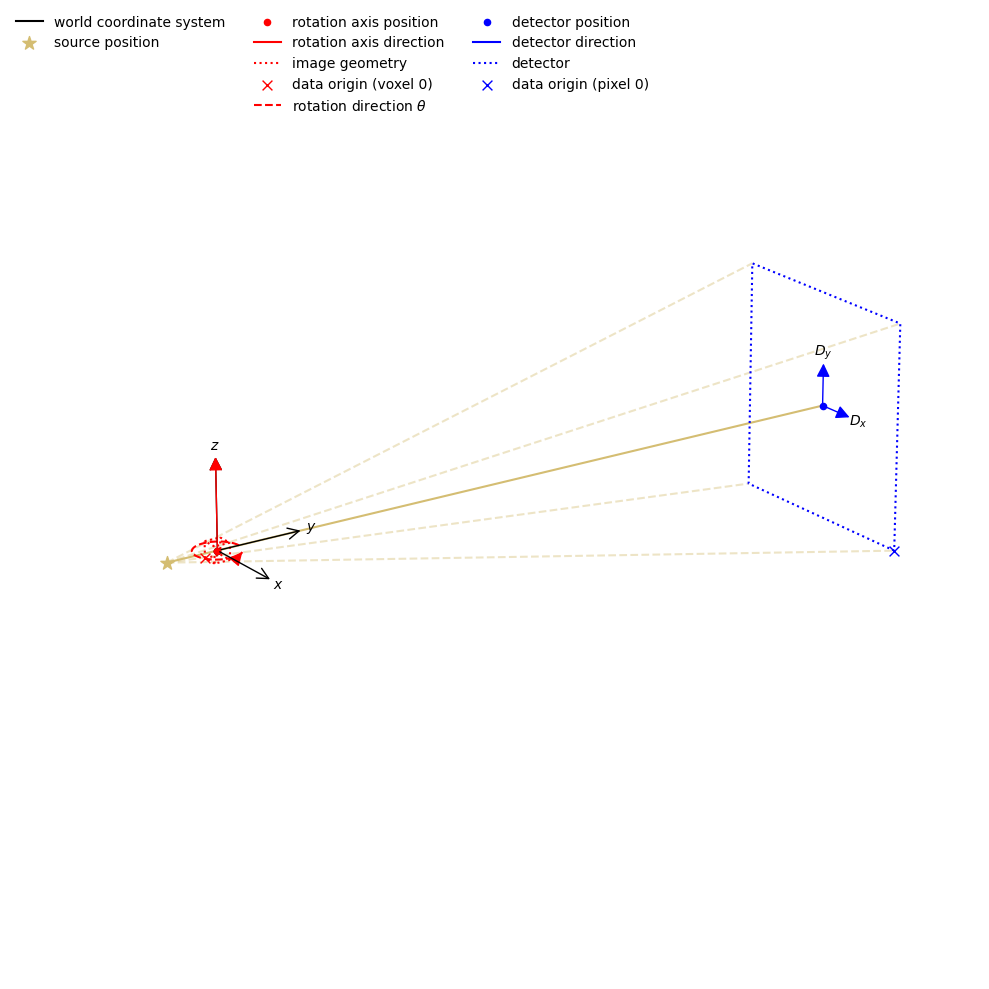

In [13]:
show_geometry(ag_big);

### Data and geometry

In [ ]:
# Region of interest
roi = {'axis_0': (0, num_projs, skip), 'axis_1': -1, 'axis_2': (0, 1000,1)}
reader = TIFFStackReader(file_name='cttest', transpose=False, roi=roi)

In [12]:
big_raw_data = reader.read_as_AcquisitionData(ag_big)

Number of dimensions: 3
Shape: (100, 1000, 1000)
Axis labels: (<AcquisitionDimension.ANGLE: 'angle'>, <AcquisitionDimension.VERTICAL: 'vertical'>, <AcquisitionDimension.HORIZONTAL: 'horizontal'>)



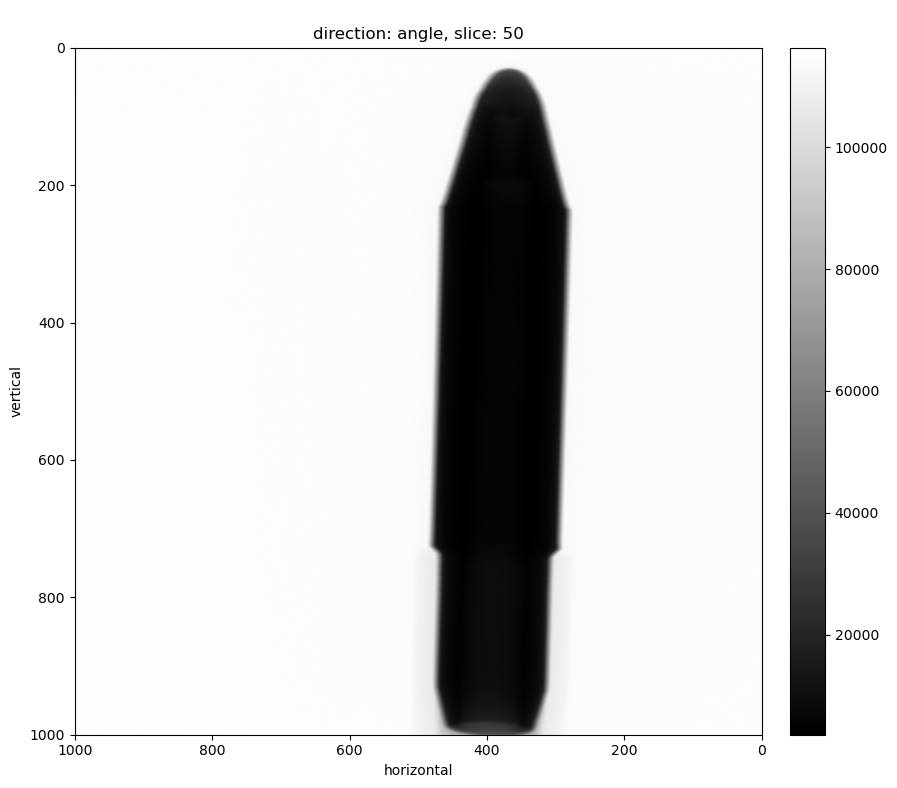

In [14]:
del reader
print(big_raw_data)
show2D(datacontainers=big_raw_data, origin='upper-right');

#### Transmission data slicer

In [15]:
islicer(big_raw_data)

### Data processing from transmission images to absorption images

max_k = 11556, about 70.532 of the maximum (of 14 bit int)


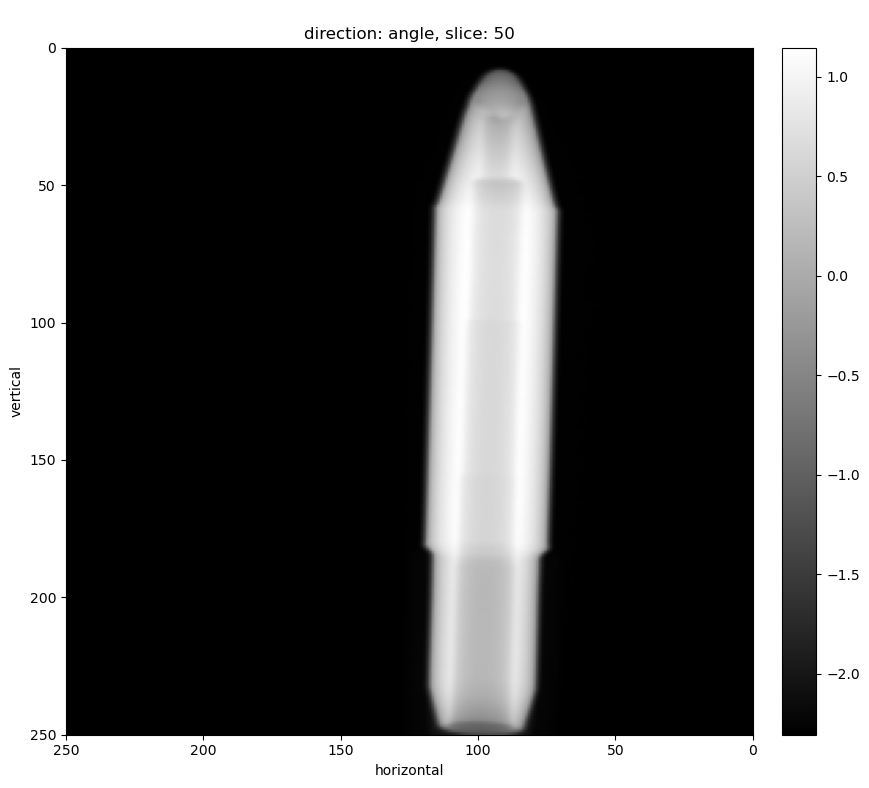

Number of dimensions: 3
Shape: (100, 250, 250)
Axis labels: (<AcquisitionDimension.ANGLE: 'angle'>, <AcquisitionDimension.VERTICAL: 'vertical'>, <AcquisitionDimension.HORIZONTAL: 'horizontal'>)



In [17]:
from cil.processors import Binner, TransmissionAbsorptionConverter

binning = 4 # Downsampling constant
binner_processor = Binner(roi={'horizontal': (None, None, binning), 'vertical': (None, None, binning)})
binner_processor.set_input(big_raw_data)

# Binned data
data = binner_processor.get_output()

max_k = params['FreeRay'] # Maximum intensity
print(f'{max_k = }, about {100*max_k / 2**14:.3f} of the maximum (of 14 bit int)')
transmission_processor = TransmissionAbsorptionConverter(white_level=max_k)
transmission_processor.set_input(data)
transmission_processor.get_output(out=data)

show2D(data, origin='upper-right')
print(data)

#### Absorption data slicer

In [18]:
islicer(data)

In [19]:
# Delete unnecessary thing to free memory
del big_raw_data
del binner_processor
del transmission_processor

### Image geometry and data

In [20]:
# Setup for the image geometry
(_, nz, nx) = data.shape

# Image geometry
ig = data.geometry.get_ImageGeometry()
ig.voxel_num_x = nx
ig.voxel_num_y = nx
ig.voxel_num_z = nz
print(ig)

Number of channels: 1
channel_spacing: 1.0
voxel_num : x250,y250,z250
voxel_size : x0.05733048518783027,y0.05733048518783027,z0.05733048518783027
center : x0,y0,z0



### CT reconstructions

Feldkamp-Davis-Kress (FDK) reconstruction algorithm for 3D cone beam

In [21]:
from cil.recon import FDK

data.reorder('tigre')
fdk = FDK(data)

fdk_recon = fdk.run()

FDK recon

Input Data:
	angle: 100
	vertical: 250
	horizontal: 250

Reconstruction Volume:
	vertical: 250
	horizontal_y: 250
	horizontal_x: 250

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 9
	Filter_inplace: False



(250, 250, 250)


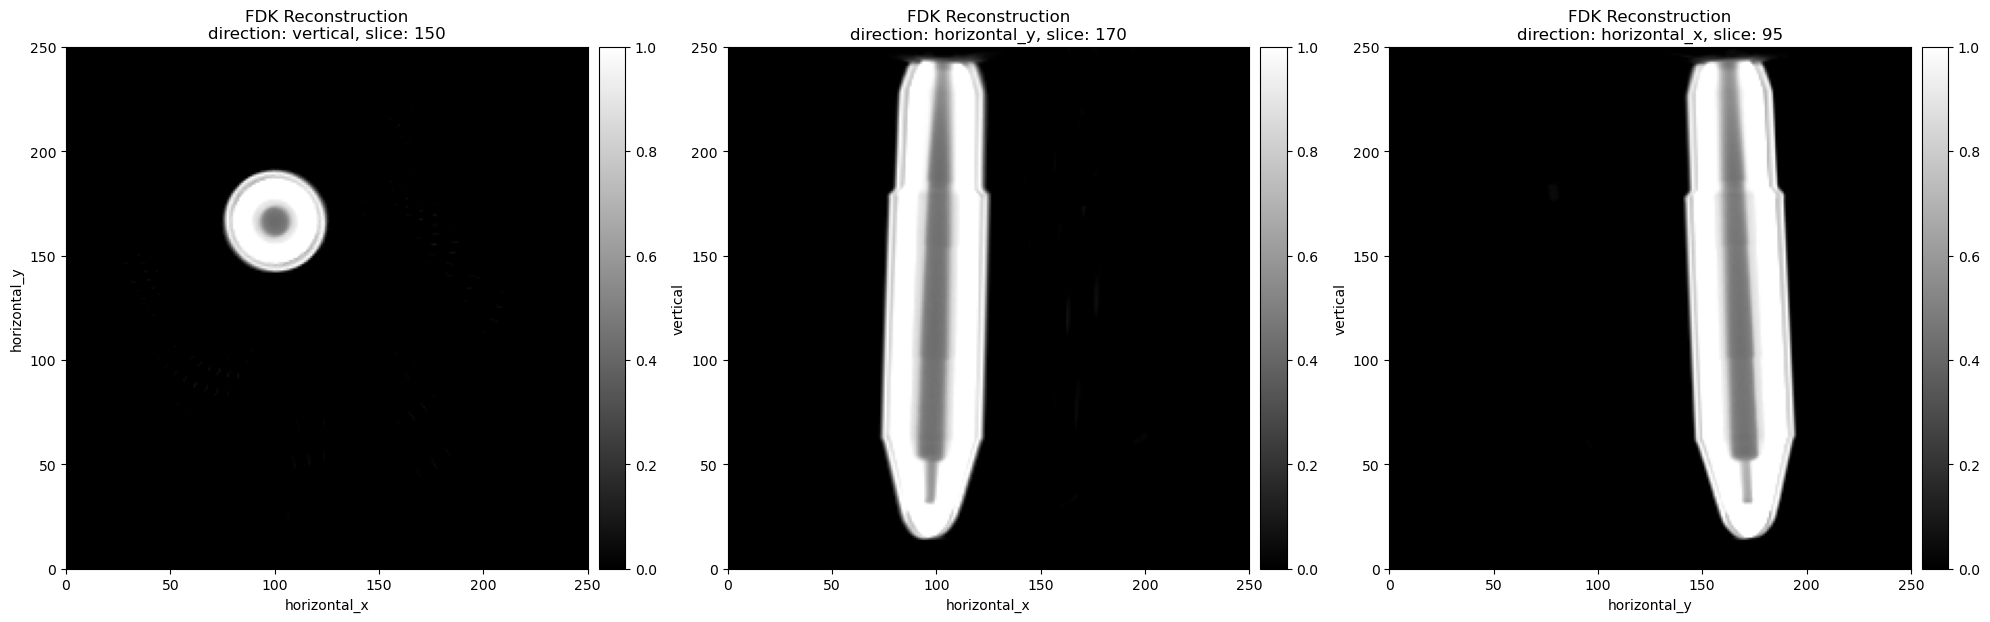

In [53]:
print(fdk_recon.shape)
ub = 1 # Upper bound
show2D(fdk_recon, size=(20,10), fix_range=(0,ub), title=f'FDK Reconstruction', num_cols=3, slice_list=[(0, 150), (1, 170), (2, 95)]);

In [48]:
# islicer(fdk_recon, minmax=(0, ub), direction=2)
#islicer(fdk_recon, size=(10,10), title='FDK Reconstruction', minmax=(0,ub))
islicer(fdk_recon, minmax=(0,ub), direction=1)

Total Variation (TV) reconstruction algorithm


The goal is to obtain the following: $\hat{x}=\argmin_x \{f(x)+g(x)\}$ where $f$ is a least squares objective function  $\|\boldsymbol{d}-A\boldsymbol{x}|^2_2$
and $g$ is a total variation function $\alpha TV(x)$, where $\alpha$ is a regularization constant. $\hat{x}$ is the reconstructed image, that is close to the true case.

In [81]:
data.reorder('astra')

# Acquisition geometry
ag = data.geometry

A = ProjectionOperator(ig, ag, 'gpu')
f = LeastSquares(A, data)
h = TotalVariation()

alpha = 1e-5 # Regulazation constant

tv_fista = FISTA(initial=ig.allocate(0), f=f, g=alpha*h)

In [82]:
tv_fista.run(20)

  0%|          | 0/20 [00:00<?, ?it/s]

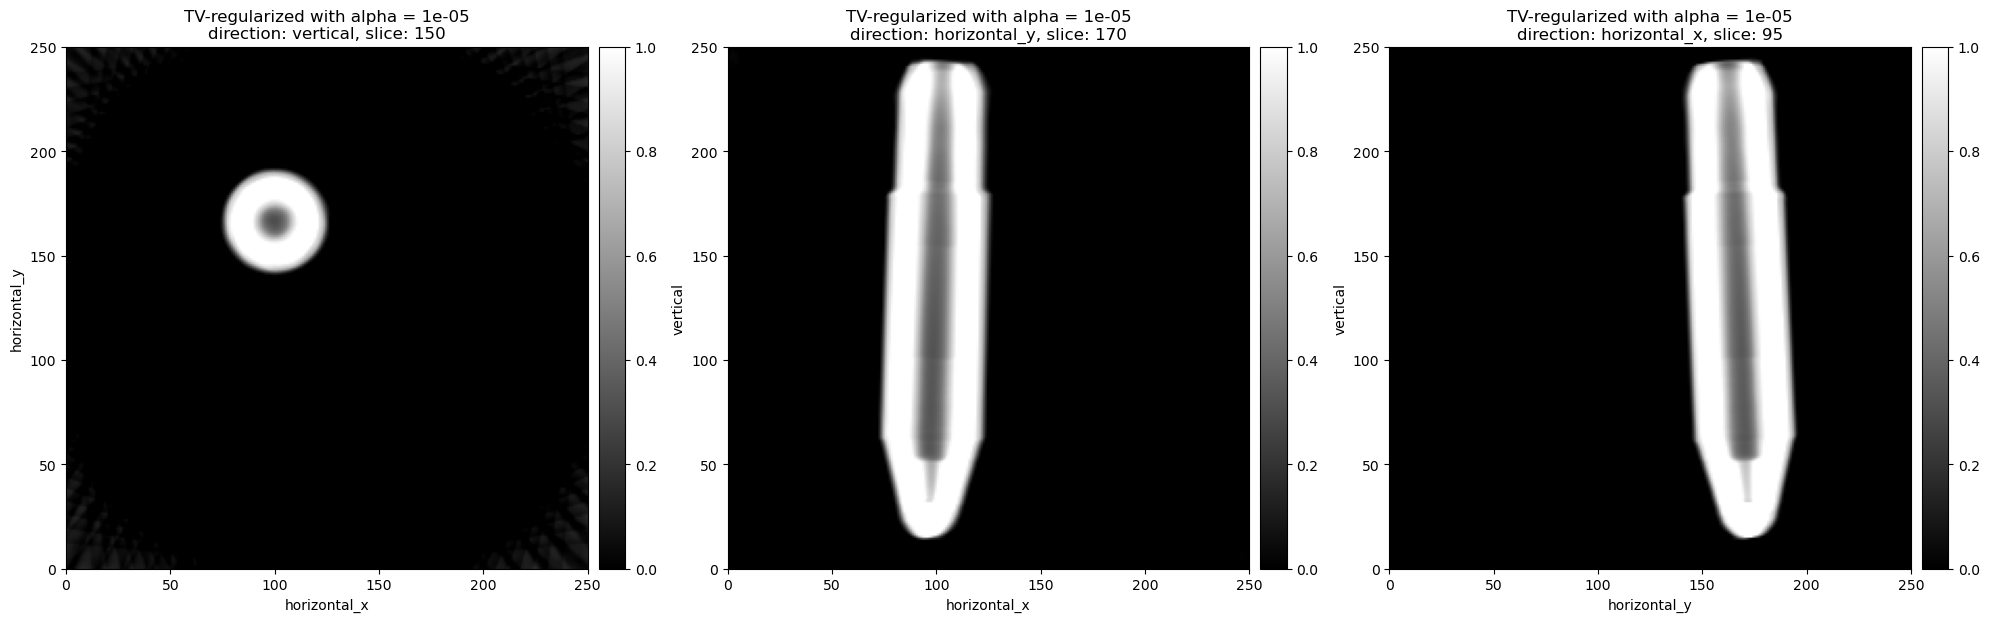

In [83]:
x_tv = tv_fista.get_output()
show2D(x_tv, size=(20, 10), fix_range=(0,ub), title=f'TV-regularized with {alpha = }', num_cols=3, slice_list=[(0, 150), (1, 170), (2, 95)]);

In [ ]:
islicer(x_tv, minmax=(0,ub), direction=2)

In [78]:
from cil.plugins.ccpi_regularisation.functions import FGP_TV

data.reorder('astra')

# Acquisition geometry
ag = data.geometry

A = ProjectionOperator(ig, ag, 'gpu')
f = LeastSquares(A, data)
# h = TotalVariation()
h = FGP_TV(device='gpu')

alpha = 1e-5 # Regulazation constant

tv_fista = FISTA(initial=ig.allocate(0), f=f, g=alpha*h)

/tmp/ipykernel_6764/641212158.py:11: UserWarning: Note that the default behaviour now sets the nonnegativity constraint to False 
  h = FGP_TV(device='gpu')


In [79]:
tv_fista.run(20)

  0%|          | 0/20 [00:00<?, ?it/s]

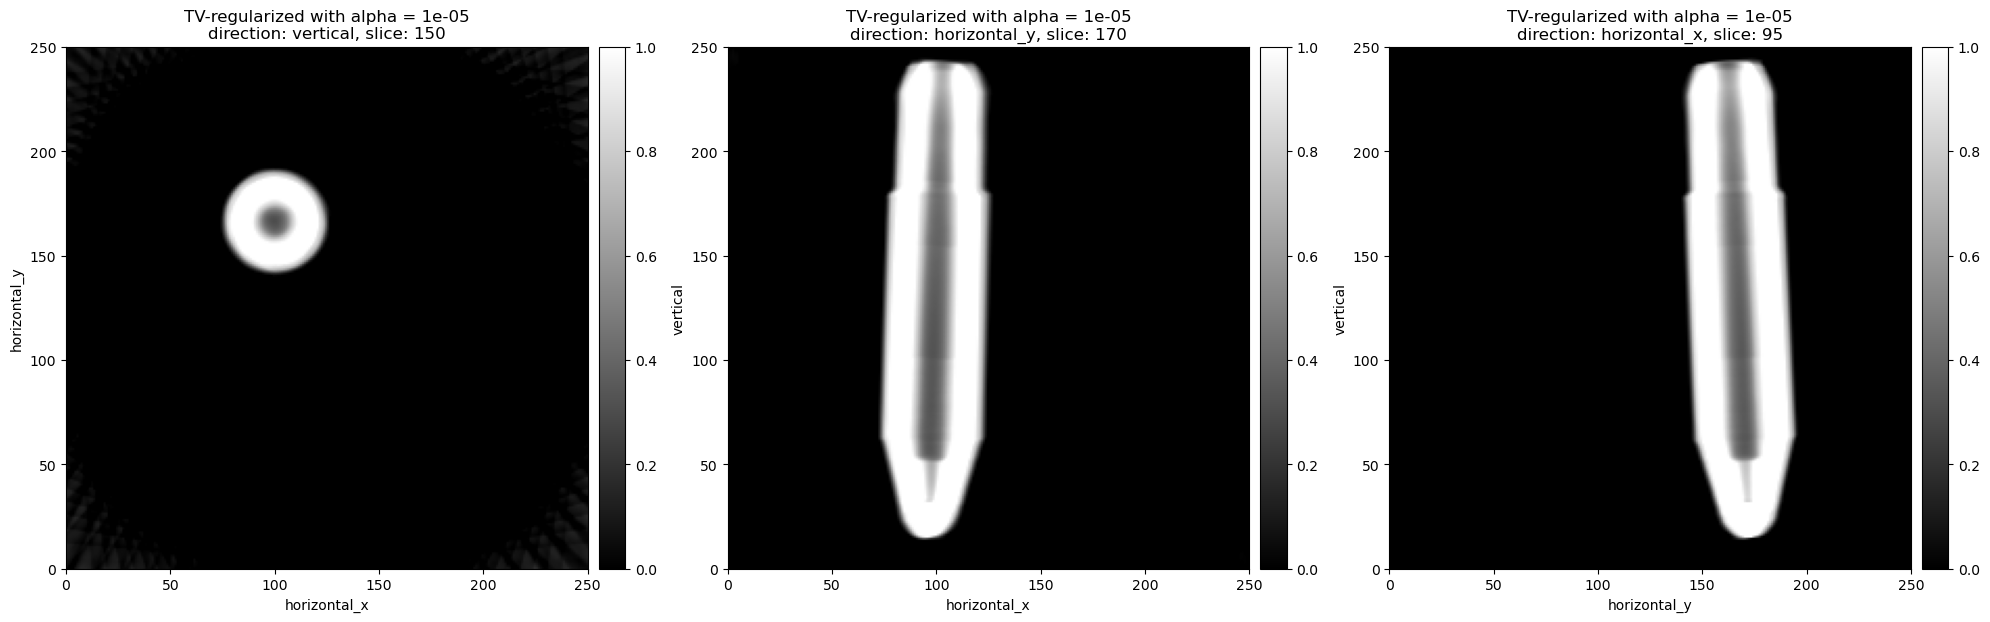

In [80]:
x_tv = tv_fista.get_output()
show2D(x_tv, size=(20, 10), fix_range=(0,ub), title=f'TV-regularized with {alpha = }', num_cols=3, slice_list=[(0, 150), (1, 170), (2, 95)]);